In [1]:
import ehr_utils, ehr_models
import os
import pickle
import numpy as np
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils import compute_sample_weight
from imblearn.over_sampling import SMOTE
import shutil

In [2]:
print("=== 步骤1：获取训练集和测试集 ===")
X_train, X_test, y_train, y_test = ehr_utils.preprocess_ehr_train_test_data('data_processed/benbu_baseline_cleaned_onehot.csv')
print(f"原始训练集大小：{X_train.shape}")
print(f"原始测试集大小：{X_test.shape}")

=== 步骤1：获取训练集和测试集 ===
总特征数：96，需要log1p变换的特征数：66
训练集样本数：8000，验证集样本数：2000
原始训练集大小：(8000, 96)
原始测试集大小：(2000, 96)


In [3]:
models_dir = 'models'
model_files = [f for f in os.listdir(models_dir) if f.endswith('.pkl')]
loaded_models = []

for file in model_files:
    with open(os.path.join(models_dir, file), 'rb') as f:
        model = pickle.load(f)
        loaded_models.append(model)

In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_predict

train_meta = np.zeros((len(X_train), len(loaded_models)))
test_meta = np.zeros((len(X_test), len(loaded_models)))

for i, model in enumerate(loaded_models):
    # 使用交叉验证预测避免过拟合
    train_meta[:, i] = cross_val_predict(model, X_train, y_train, cv=5, method='predict')
    test_meta[:, i] = model.predict(X_test)  # 测试集可直接预测

# 构建新的训练集和测试集
X_train_meta = np.hstack((X_train, train_meta))
X_test_meta = np.hstack((X_test, test_meta))

# 训练XGBoost模型
xgb_model = xgb.XGBClassifier(
    colsample_bytree=1.0,
    device='gpu',
    eval_metric="auc",
    gamma=0.0,
    learning_rate=0.022403069086742198,
    max_depth=5,
    min_child_weight=100,
    n_estimators=589,
    n_jobs=-1,
    random_state=42,
    reg_alpha=0.14314863930500873,
    reg_lambda=100.0,
    subsample=0.7300248552604385
)

# 交叉验证
cv_scores = cross_val_score(xgb_model, X_train_meta, y_train, cv=5, scoring='accuracy')
print(f'Cross-validation accuracy: {cv_scores.mean():.4f}')

# 训练最终模型
xgb_model.fit(X_train_meta, y_train)

# 预测
y_pred = xgb_model.predict(X_test_meta)

# 评估
print(f'Test accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'Test F1 score: {f1_score(y_test, y_pred):.4f}')

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.7911667142271672, subsample=0.6 will be ignored. Current value: bagging_fraction=0.7911667142271672
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_

d:\Cache\Conda\envs\EHR172\Lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
d:\Cache\Conda\envs\EHR172\Lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
d:\Cache\Conda\envs\EHR172\Lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
d:\Cache\Conda\envs\EHR172\Lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
d:\Cache\Conda\envs\EHR172\Lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'lib

Cross-validation accuracy: 0.6999
Test accuracy: 0.7000
Test F1 score: 0.0000


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.0
[LightGBM] [Warning] bagging_fraction is set=0.7911667142271672, subsample=0.6 will be ignored. Current value: bagging_fraction=0.7911667142271672
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


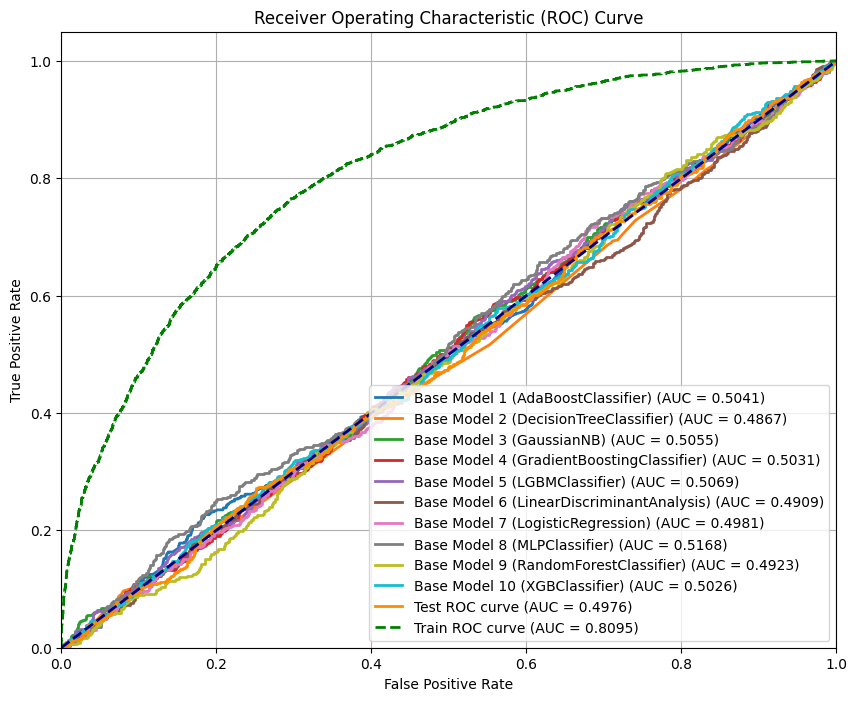

In [ ]:
import os
import pickle
import numpy as np
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
import matplotlib.pyplot as plt

# 加载数据和预训练模型
X_train, X_test, y_train, y_test = ehr_utils.preprocess_ehr_train_test_data('data_processed/benbu_baseline_cleaned_onehot.csv')

models_dir = 'models'
model_files = [f for f in os.listdir(models_dir) if f.endswith('.pkl')]
loaded_models = []

for file in model_files:
    with open(os.path.join(models_dir, file), 'rb') as f:
        model = pickle.load(f)
        loaded_models.append(model)

print(f"成功加载 {len(loaded_models)} 个基础模型")

# 使用predict_proba生成meta特征
n_models = len(loaded_models)
train_meta_prob = np.zeros((len(X_train), n_models))
test_meta_prob = np.zeros((len(X_test), n_models))

for i, model in enumerate(loaded_models):
    print(f"正在处理基础模型 {i+1}/{n_models} ...")
    try:
        train_meta_prob[:, i] = model.predict_proba(X_train)[:, 1]
        test_meta_prob[:, i] = model.predict_proba(X_test)[:, 1]
    except Exception as e:
        print(f"  警告：模型 {i} 不支持 predict_proba 或出错: {e}")
        # 如果不支持predict_proba，则回退到predict方法
        train_meta_prob[:, i] = model.predict(X_train)
        test_meta_prob[:, i] = model.predict(X_test)

# 构建增强特征集
X_train_meta = np.hstack((X_train, train_meta_prob))  # 原始 + 10 概率
X_test_meta = np.hstack((X_test, test_meta_prob))

# 设置XGBoost参数
xgb_params = dict(
    colsample_bytree=1.0,
    device='gpu',
    eval_metric="auc",
    gamma=0.0,
    learning_rate=0.022403069086742198,
    max_depth=5,
    min_child_weight=100,
    n_estimators=589,
    n_jobs=-1,
    random_state=42,
    reg_alpha=0.14314863930500873,
    reg_lambda=100.0,
    subsample=0.7300248552604385
)

# 训练仅用10个概率特征的二级模型
xgb_meta_only = xgb.XGBClassifier(**xgb_params)
xgb_meta_only.fit(train_meta_prob, y_train)

# 训练用原始特征加10个概率特征的二级模型
xgb_full = xgb.XGBClassifier(**xgb_params)
xgb_full.fit(X_train_meta, y_train)

# 绘制ROC曲线
plt.figure(figsize=(12, 9))

# 为每个基础模型绘制ROC曲线
base_colors = plt.cm.tab10(np.linspace(0, 1, n_models))
for i, model in enumerate(loaded_models):
    try:
        y_proba_base = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba_base)
        auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=base_colors[i], lw=1.5,
                 label=f'Base Model {i+1} (AUC={auc_val:.4f})')
    except:
        continue

# 仅用10个概率特征的二级模型的ROC曲线
y_proba_meta_train = xgb_meta_only.predict_proba(train_meta_prob)[:, 1]
y_proba_meta_test = xgb_meta_only.predict_proba(test_meta_prob)[:, 1]

fpr_train_a, tpr_train_a, _ = roc_curve(y_train, y_proba_meta_train)
fpr_test_a, tpr_test_a, _ = roc_curve(y_test, y_proba_meta_test)
auc_train_a = auc(fpr_train_a, tpr_train_a)
auc_test_a = auc(fpr_test_a, tpr_test_a)

plt.plot(fpr_test_a, tpr_test_a, color='red', lw=2.5,
         label=f'Model A (Meta-Only) Test (AUC={auc_test_a:.4f})')
plt.plot(fpr_train_a, tpr_train_a, color='red', lw=2, linestyle='--',
         label=f'Model A Train (AUC={auc_train_a:.4f})')

# 用原始特征加10个概率特征的二级模型的ROC曲线
y_proba_full_train = xgb_full.predict_proba(X_train_meta)[:, 1]
y_proba_full_test = xgb_full.predict_proba(X_test_meta)[:, 1]

fpr_train_b, tpr_train_b, _ = roc_curve(y_train, y_proba_full_train)
fpr_test_b, tpr_test_b, _ = roc_curve(y_test, y_proba_full_test)
auc_train_b = auc(fpr_train_b, tpr_train_b)
auc_test_b = auc(fpr_test_b, tpr_test_b)

plt.plot(fpr_test_b, tpr_test_b, color='darkorange', lw=2.5,
         label=f'Model B (Full) Test (AUC={auc_test_b:.4f})')
plt.plot(fpr_train_b, tpr_train_b, color='orange', lw=2, linestyle='--',
         label=f'Model B Train (AUC={auc_train_b:.4f})')

# 随机猜测线
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--', label='Random (AUC=0.5)')

# 图表设置
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right", fontsize=9, ncol=2)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n✅ 所有 ROC 曲线已绘制完成！")

In [ ]:
import shap
import matplotlib.pyplot as plt

# -------------------------------------
# 1. 找到一级模型里的 XGBoost
# -------------------------------------
xgb_base_idx = None
for idx, model in enumerate(loaded_models):
    if isinstance(model, xgb.XGBClassifier):
        xgb_base_idx = idx
        break
if xgb_base_idx is None:
    raise RuntimeError('一级模型里找不到 XGBClassifier，请检查 pkl 文件')

base_xgb = loaded_models[xgb_base_idx]   # 一级 xgb 模型
print(f'一级 XGBoost 位于 loaded_models[{xgb_base_idx}]')

# -------------------------------------
# 2. 计算 SHAP 值
# -------------------------------------
# 2.1 一级模型（用训练集子集提速，可换成 X_test）
background_base = shap.sample(X_train, 100)  # 背景数据集
explainer_base = shap.TreeExplainer(base_xgb, data=background_base)
shap_base = explainer_base.shap_values(background_base)  # 返回 (n_sample, n_feat)

# 2.2 二级 Meta-Only 模型
background_meta = shap.sample(train_meta_prob, 100)
explainer_meta = shap.TreeExplainer(xgb_meta_only, data=background_meta)
shap_meta = explainer_meta.shap_values(background_meta)

# 2.3 二级 Full 模型
background_full = shap.sample(X_train_meta, 100)
explainer_full = shap.TreeExplainer(xgb_full, data=background_full)
shap_full = explainer_full.shap_values(background_full)

# -------------------------------------
# 3. 画图
# -------------------------------------
plt.rcParams['font.size'] = 10
fig = plt.figure(figsize=(18, 12))

# ---- 行1：特征重要性 bar ----
ax1 = plt.subplot(2, 3, 1)
shap.summary_plot(shap_base, background_base, plot_type="bar", show=False)
ax1.set_title('(a) Base XGB — 特征重要性')

ax2 = plt.subplot(2, 3, 2)
shap.summary_plot(shap_meta, background_meta, plot_type="bar", show=False)
ax2.set_title('(b) Meta-Only XGB — 特征重要性')

ax3 = plt.subplot(2, 3, 3)
shap.summary_plot(shap_full, background_full, plot_type="bar", show=False)
ax3.set_title('(c) Full XGB — 特征重要性')

# ---- 行2：蜂群图 summary_plot ----
ax4 = plt.subplot(2, 3, 4)
shap.summary_plot(shap_base, background_base, plot_type="dot", show=False)
ax4.set_title('(d) Base XGB — 蜂群图')

ax5 = plt.subplot(2, 3, 5)
shap.summary_plot(shap_meta, background_meta, plot_type="dot", show=False)
ax5.set_title('(e) Meta-Only XGB — 蜂群图')

ax6 = plt.subplot(2, 3, 6)
shap.summary_plot(shap_full, background_full, plot_type="dot", show=False)
ax6.set_title('(f) Full XGB — 蜂群图')

plt.tight_layout()
plt.savefig('shap_comparison_6in1.png', dpi=300)
plt.show()

# -------------------------------------
# 4. 单独保存二级模型对“元特征”的重要性（方便看哪个一级模型贡献大）
# -------------------------------------
plt.figure(figsize=(5, 4))
shap.summary_plot(shap_meta, background_meta, plot_type="bar", max_display=10, show=False)
plt.title('Meta-Only 模型：10 个一级模型概率的重要性')
plt.tight_layout()
plt.savefig('meta_only_bar.png', dpi=300)
plt.show()